This notebook is for calculating identities between all BRENDA sequences and their closest characterized one.<br/><br/>Copyright (C) 2020-2021  Martin Engqvist Lab<br/>This program is free software: you can redistribute it and/or modify<br/>it under the terms of the GNU General Public License as published by<br/>the Free Software Foundation, either version 3 of the License, or<br/>(at your option) any later version.<br/>This program is distributed in the hope that it will be useful,<br/>but WITHOUT ANY WARRANTY; without even the implied warranty of<br/>MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the<br/>GNU General Public License for more details.<br/>You should have received a copy of the GNU General Public License<br/>along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from os.path import join, dirname, basename, exists, isdir

### Load environmental variables from the project root directory ###
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

# now you can get the variables using their names

# Check whether a network drive has been specified
DATABASE = os.environ.get("NETWORK_URL")
if DATABASE == 'None':
    pass
else:
    pass
    #mount network drive here

# set up directory paths
CURRENT_DIR = os.getcwd()
PROJ = dirname(dotenv_path) # project root directory

DATA = join(PROJ, 'data') #data directory
RAW_EXTERNAL = join(DATA, 'raw_external') # external data raw directory
RAW_INTERNAL = join(DATA, 'raw_internal') # internal data raw directory
INTERMEDIATE = join(DATA, 'intermediate') # intermediate data directory
FINAL = join(DATA, 'final') # final data directory

RESULTS = join(PROJ, 'results') # output directory
FIGURES = join(RESULTS, 'figures') # figure output directory
PICTURES = join(RESULTS, 'pictures') # picture output directory


folder_name = 'brenda_2019_2'
if folder_name != '':
    #make folders if they don't exist
    if not exists(join(RAW_EXTERNAL, folder_name)):
        os.makedirs(join(RAW_EXTERNAL, folder_name))

    if not exists(join(INTERMEDIATE, folder_name)):
        os.makedirs(join(INTERMEDIATE, folder_name))

    if not exists(join(FINAL, folder_name)):
        os.makedirs(join(FINAL, folder_name))

print('Standard variables loaded, you are good to go!')

Standard variables loaded, you are good to go!


In [2]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Align.Applications import MuscleCommandline
from Bio import AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
import io

from subprocess import Popen, PIPE
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import spearmanr
import multiprocessing

from brenparse import parser


# https://doi.org/10.1186/s13059-017-1319-7
# https://github.com/aziele/alfpy
# http://www.combio.pl/alfree
# pip install alfpy

from alfpy.utils import seqrecords
from alfpy import word_distance
from alfpy import word_pattern
from alfpy import word_vector
from alfpy.utils import distmatrix
from alfpy import ncd

from tqdm import tqdm

# Outline
This notebook aims to compute the identity between each sequence in BRENDA (clustered at 90%) and the closest characterized one. The way to make this computationally feasible is to use a k-tuple measure to find the most similar sequence, and then to carry out a pairwise alignment. The notbook follows these steps:

(1) Identify the k-tuple measure that best corresponds to sequence alignments

(2) Compute the k-tuple measure for all proteins

(3) Make multiple sequence alignments

# (1)

# In the first part I compute identity between characterized sequences and all sequences in clustered fasta

I want to use the alignment-free k-tuple measure to obtain the best match between characterized and uncharacterized sequences, then do a pairwise alignment to get the correct identiy. However, I do not know the best settings for the k-tuple algorithm to mimic an alignment. Will have to explore this first.

#### Compute all vs all identity using alignment

In [3]:

def pairwise_align(id1, id2, seq1, seq2):
    '''
    Perform pairwise alignment.
    '''
    records = '>%s\n%s\n>%s\n%s' % (id1, seq1, id2, seq2) #prepare 'virtual' FASTA file
    records_handle = io.StringIO(records) #turn string into a handle
    tempdata = records_handle.getvalue()
    muscle_cline = MuscleCommandline()
    stdout, stderr = muscle_cline(stdin=tempdata)
    
    with io.StringIO(stdout) as fasta:
        aln = SeqIO.parse(fasta, "fasta")

        output = []
        for entry in aln:
            header = entry.description
            seq = entry.seq

            output.append(header)
            output.append(seq)
        
    return output




def pair_ident(Seq1, Seq2, single_gaps=True):
    '''
    Takes two aligned sequences and returns their percent identity.
    Assumes that Seq1 and Seq2 are sequence strings
    '''

    l=0.0 # counts alignment length, excluding identical gaps, but including single gaps
    n=0.0 # count number of single gaps
    i=0.0 # counts identity hits


    for j in range(len(Seq2)):
        if Seq1[j] == '-' and Seq2[j] == '-': #DON'T count identical gaps towards alignment length
            pass
        else:
            if Seq2[j] == Seq1[j]:
                i += 1 #count matches
            elif Seq2[j] == '-' or Seq1[j] == '-':
                n += 1 #count number of single gaps
            l += 1 #count total length with single gaps

    if single_gaps is True: #include single gaps
        percent = round(100*(i/l),1) #calculate identity

    elif single_gaps is False: #exclude single gaps
        if n >= l:
            percent = 0.0
        else:
            percent = round(100*(i/(l-n)),1) #calculate identity

    return percent



def get_random_selection(ec, num_seqs, seed=1):
    '''
    Randomnly select sequences from 1.1.3.15 on which to do all vs all identities
    '''
    random.seed(seed)

    # first get all sequences
    all_seqs = []
    all_ids = []
    filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'ec_identity_clustering')
    fasta_filepath = join(filepath, '%s_clustered_sequences_90_augmented.fasta' % ec)
    fasta = SeqIO.parse(fasta_filepath, "fasta")
    for record in fasta:
        header = record.description
        uid = header.split(';')[0].rstrip()
        seq = record.seq

        all_ids.append(uid)
        all_seqs.append(str(seq))


    # now select sequences at random
    sampling = random.choices(list(range(0, len(all_ids))), k=num_seqs)
    my_seqs = [all_seqs[i] for i in sampling]
    my_ids = [all_ids[i] for i in sampling]
    
    return my_ids, my_seqs




def compute_matrix():
    # compute identities using alignment 
    id_matrix = np.zeros((num_seqs, num_seqs))
    for i in range(0, len(my_ids)):
        for j in (range(0, len(my_ids))):
            if j >= i:
                id1 = my_ids[i]
                seq1 = my_seqs[i]

                id2 = my_ids[j]
                seq2 = my_seqs[j]

                output = pairwise_align(id1=id1, id2=id2, seq1=seq1, seq2=seq2)

                aln_seq1 = output[1]
                aln_seq2 = output[3]

                identity = pair_ident(Seq1=aln_seq1, Seq2=aln_seq2, single_gaps=True)

                id_matrix[i, j] = identity
                id_matrix[j, i] = identity

    # convert to distance matrix
    dist_matrix = 1-(id_matrix/100)
    
    return dist_matrix


num_seqs = 400
my_ids, my_seqs = get_random_selection(ec='1.1.3.15', num_seqs=num_seqs)

outfile = join(INTERMEDIATE, 'BRENDA_for_paper', 'alignment_distmatrix_for_ktup_settings_evaluation.tsv')
if not exists(outfile):
    dist_matrix = compute_matrix()
    np.savetxt(outfile, dist_matrix, delimiter='\t')
else:
    print('Loading pre-existing distance matrix')
    dist_matrix = np.loadtxt(outfile, delimiter='\t')

Loading pre-existing distance matrix


#### Compute distances using several k-tuple measures

In [4]:

seq_records = seqrecords.SeqRecords(id_list=my_ids, seq_list=my_seqs)


settings = []
matrixes = []
for measure in ['angle_cos_diss',
                'angle_cos_evol',
                'braycurtis',
                'canberra',
                'chebyshev',
                'euclid_norm',
                'euclid_squared',
                'google',
                'jsd',
                'kld',
                'lcc',
                'manhattan',
                'minkowski']:
    for word_vec in ['counts']:
        for word_size in [2, 3, 4]:

            settings.append('vector type: %s, word size: %s, dist measure: %s' % (word_vec, word_size, measure))

            p = word_pattern.create(seq_records.seq_list, word_size=word_size)
            
            if word_vec == 'counts':
                counts = word_vector.Counts(seq_records.length_list, p)
                dist = word_distance.Distance(counts, measure)
                
            elif word_vec == 'freqs':
                freqs = word_vector.Freqs(seq_records.length_list, p)
                dist = word_distance.Distance(freqs, measure)
                
            else:
                raise ValueError
                
                
            matrix = distmatrix.create(seq_records.id_list, dist)
            matrixes.append(matrix)


#### Plot k-tuple vs alignment sores

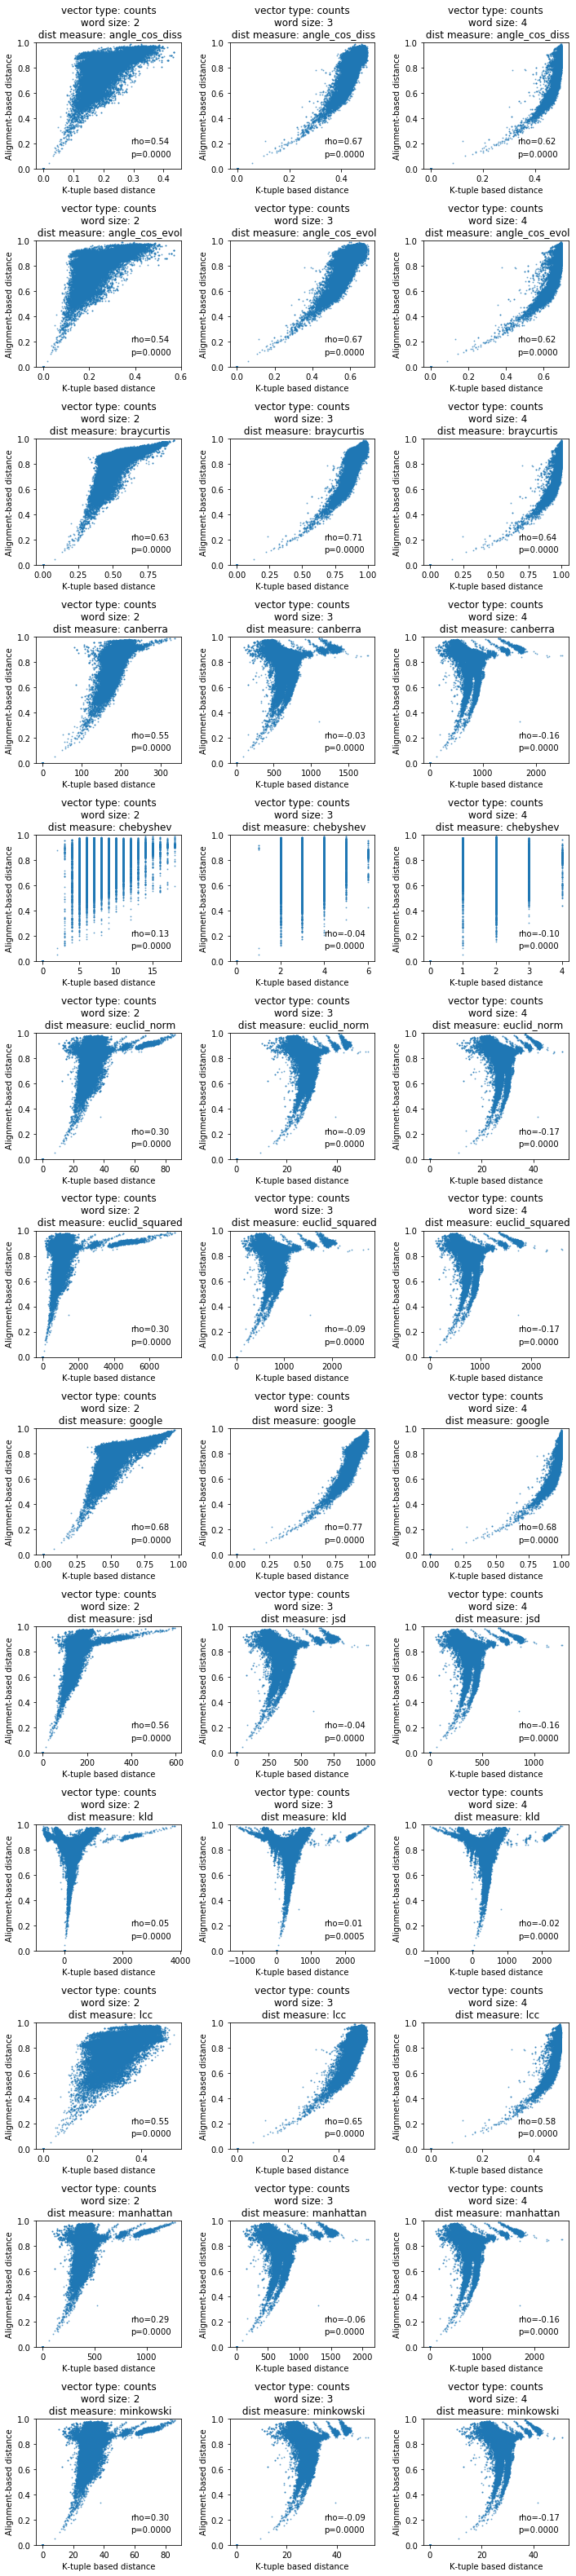

In [5]:
ncols = 3
nrows = int(len(matrixes)/ncols)

fig = plt.figure(figsize=(10,44))

for i in range(0, len(matrixes)):
    x = list(matrixes[i].data[np.triu_indices(num_seqs, k=1)])
    y = list(dist_matrix[np.triu_indices(num_seqs, k=1)])

    plt.subplot(nrows, ncols, i+1)
    plt.scatter(x, y, s=1, alpha=0.5)
    plt.ylim(0, 1)
    
    # calculate spearman correlation
    coef, p = spearmanr(x, y)
    plt.text(x=max(x)-(max(x)-min(x))/3, y=0.2, s='rho=%.2f' % coef)
    plt.text(x=max(x)-(max(x)-min(x))/3, y=0.1, s='p=%.4f' % p)

    plt.xlabel('K-tuple based distance')
    plt.ylabel('Alignment-based distance')
    plt.title(settings[i].replace(',', '\n'))


plt.tight_layout()


plt.savefig(join(FIGURES, 'supplemental_k-tuple_settings_plot.png'), dpi=300, 
        facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)


plt.savefig(join(FIGURES, 'supplemental_k-tuple_settings_plot.pdf'),
        facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

From this I conclude that google with a word size of 3 is the best one to use, closely followed by braycurtis also with a wordsize of 3.

### Want to see the simlarity between the randomly selected sequences

'vector type: counts, word size: 3, dist measure: google'

'mean similartiy alignment: 0.18250051378446117'

'mean similarity k-tuple: 0.09639741897940954'

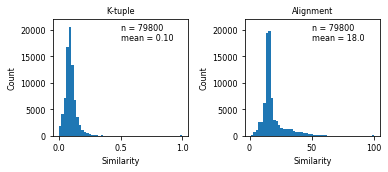

In [6]:

fig = plt.figure(figsize=(5.5, 2.5))

# histogram of k-tuple similarities
plt.subplot(1, 2, 1)
display(settings[22])

ktup_vals = 1-matrixes[22].data[np.triu_indices(num_seqs, k=1)]
plt.hist(ktup_vals,
        bins=50)

plt.text(x=0.5, y=20000, s='n = {}'.format(len(ktup_vals)), fontsize=8)
plt.text(x=0.5, y=18000, s='mean = %.2f' % ktup_vals.mean(), fontsize=8)

plt.xlabel('Similarity', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(np.arange(0, 21000, 5000), fontsize=8)
plt.ylim((0, 22000))
plt.title('K-tuple', fontsize=8)



# histogram of alignment similarities
plt.subplot(1, 2, 2)
aln_vals = 1-dist_matrix[np.triu_indices(num_seqs, k=1)]
plt.hist(aln_vals*100, 
        bins=50)

plt.text(x=50, y=20000, s='n = {}'.format(len(aln_vals)), fontsize=8)
plt.text(x=50, y=18000, s='mean = {}'.format(round(aln_vals.mean()*100)), fontsize=8)

plt.xlabel('Similarity', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(np.arange(0, 21000, 5000), fontsize=8)
plt.ylim((0, 22000))
plt.title('Alignment', fontsize=8)

plt.tight_layout()



plt.savefig(join(FIGURES, 'supplemental_k-tuple_similarity_plot.png'), dpi=300, 
        facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)


plt.savefig(join(FIGURES, 'supplemental_k-tuple_similarity_plot.pdf'),
        facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)


display('mean similartiy alignment: {}'.format(aln_vals.mean()))
display('mean similarity k-tuple: {}'.format(ktup_vals.mean()))

# (2)

# In the second part I use the best K-tuple method for identifying which sequence is the closest characterized one

I will use the k-tuple measure to find the most similar characterized sequences for each uncharacterized one. I will then align these to get an accurate measure of how similar they are.

In [7]:
def make_flatfile(data, header, outfile, has_uid):
    '''
    Generic function for saving the flatfiles
    '''
    out_data = [header]
    for ec in sorted(data.keys()):
        for org in sorted(data[ec].keys()):
            domain = data[ec][org]['domain']

            if domain is None:
                if has_uid is False:
                    out_data.append('%s\t%s' % (ec, org))

                elif has_uid is True:
                    for uid in data[ec][org]['uids']:
                            out_data.append('%s\t%s\t%s' % (ec, org, uid))

            else:
                if has_uid is False:
                    out_data.append('%s\t%s\t%s' % (ec, org, domain))

                elif has_uid is True:
                    for uid in data[ec][org]['uids']:
                            out_data.append('%s\t%s\t%s\t%s' % (ec, org, uid, domain))

    with open(outfile, 'w') as f:
        f.write('\n'.join(out_data))
        

        
def load_flatfile(infile, has_uid):
    '''
    Generic function for loading the flatfiles
    '''
    data = {}
    with open(infile, 'r') as f:
        f.readline()
        for line in f:

            if has_uid is True:
                if len(line.strip().split('\t')) == 4:
                    ec, org, uid, domain = line.strip().split('\t')
                else:
                    ec, org, uid = line.strip().split('\t')
                    domain = None

                if data.get(ec) is None:
                    data[ec] = {}

                if data[ec].get(org) is None:
                    data[ec][org] = {'uids':set([]), 'domain':None}

                data[ec][org]['uids'].add(uid.upper())
                data[ec][org]['domain'] = domain


            elif has_uid is False:
                if len(line.strip().split('\t')) == 3:
                    ec, org, domain = line.strip().split('\t')
                else:
                    ec, org = line.strip().split('\t')
                    domain = None

                if data.get(ec) is None:
                    data[ec] = {}

                if data[ec].get(org) is None:
                    data[ec][org] = {'uids':None, 'domain':None}

                data[ec][org]['domain'] = domain

            else:
                raise ValueError


    return data



def load_swissprot(data={}):
    '''
    Add in the SwissProt data regarding which sequences
    count as characterized.
    '''
    with open(join(RAW_EXTERNAL, 'SwissProt-2020_02-protein-evidence.tsv'), 'r') as f:
        f.readline()
        
        for line in f:
            uid, ec, org, orgid = line.strip().split('\t')
            domain = None
            
            # standardize orgname
            org = ' '.join(org.replace('.', '').split()[:2]).capitalize()
    
            if data.get(ec) is None:
                data[ec] = {}

            if data[ec].get(org) is None:
                data[ec][org] = {'uids':set([]), 'domain':None}
                
            data[ec][org]['uids'].add(uid.upper())
            data[ec][org]['domain'] = domain
            
    return data

            

def get_ec_uid_and_seq(ec):
    '''
    Return nested dictionary with EC number primary keys and uid values.
    In the second level each uid holds its protein sequence.
    Only return for uniprot identifiers from a specific ec.
    '''
    data = {}
    
    filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'ec_identity_clustering')
    fasta_filepath = join(filepath, '%s_clustered_sequences_90_augmented.fasta' % ec)
    
    # go through each entry in the fasta
    fasta = SeqIO.parse(fasta_filepath, "fasta")
    for record in fasta:
        header = record.description
        uid = header.split(';')[0].rstrip().upper()
        seq = str(record.seq)

        data[uid] = seq

    return data



def ktup(ids, seqs):
    '''
    Perform the actual ktuple calculation.
    
    Moving these bits here really helps with keeping memory consumption down.
    Reason is unclear but I assume somehow Python is better able to claim
    back memory after each computation.
    '''
    seq_records = seqrecords.SeqRecords(id_list=ids, seq_list=seqs)
    
    p = word_pattern.create(seq_records.seq_list, word_size=3)

    counts = word_vector.Counts(seq_records.length_list, p)
    dist = word_distance.Distance(counts, 'google')
    matrix = distmatrix.create(seq_records.id_list, dist)

    # get the last column (which contains data for the last added identifier)
    return matrix.data[0, 1]
    
    

def calculate_ktup_identities(package):
    '''
    Loop through all the EC classes and compare characterized sequences with uncharacterized ones.
    '''
    ec, data, tempfile = package

    # get all the sequences in clustered fasta
    seq_data = get_ec_uid_and_seq(ec)

    # assemble a list of the characterized sequences
    char_ids = []
    char_seqs = []

    if ec_org_uid_data.get(ec) is None:
        pass
    else:
        for char_org in sorted(ec_org_uid_data[ec].keys()):
            for char_uid in ec_org_uid_data[ec][char_org]['uids']:
                # skip records where sequence is missing, or if it's too long
                if 0 < len(seq_data[char_uid]) <= 10000:
                    char_ids.append(char_uid)
                    char_seqs.append(str(seq_data[char_uid]))

    print('%s: %s characterized, %s sequences total' % (ec, len(char_ids), len(seq_data.keys())))

#     print(len(char_ids))
#     print(len(char_seqs))

    # now go through the uncharacterized sequences one by one and get the closest characterized one
    counter = 0
    for organism in sorted(data.keys()):

        scores = []
        matches = []

        for uid in data[organism]['uids']:

            if counter % 500 == 0:
                print(ec, counter)
            counter += 1

            closest_match = 'None'
            best_score = 1.0

            # if none are characterized put 1 without retreiving sequence
            if char_ids == []:
                matches.append(closest_match)
                scores.append('%.3f' % best_score)
                continue

            # get sequence for this uid
            if seq_data.get(uid) is None:
                print(uid, ec)
            seq = seq_data[uid]

            # compare in turn with each of the characterized ones
            for i in range(0, len(char_ids)):
                tmp_ids = [char_ids[i]] + [uid]
                tmp_seqs = [char_seqs[i]] + [str(seq)]

                # make k-tupe calculation
                ktup_dist = ktup(tmp_ids, tmp_seqs)

                if ktup_dist < best_score:
                    best_score = ktup_dist
                    closest_match = char_ids[i]

            matches.append(closest_match)
            scores.append('%.3f' % best_score)

        data[organism]['closest_match'] = matches[:]
        data[organism]['ktuple_dist'] = scores[:]


    # now save the data to disk in case I have to re-run the computation
    write_temp_flatfile(data, tempfile)
    print('%s results written to file'  % ec)
    return None



def count_many(data):
    '''
    Takes a list of many filepaths (full os path to file) and uses paralell processing to count frequencies in these.
    Returns a list of tuples with (filepath, occurance_dictionary).
    WARNING: The order of the files in the result may not be the same as in the input.
    '''
    num_cores = multiprocessing.cpu_count()
    
    # split up det data on a per ec basis
    packages = []
    for ec in sorted(data, key=lambda ec: len(data[ec]), reverse=True): # EC class with most seq first
#     for ec in sorted(data.keys()):
        folder_path = join(INTERMEDIATE, 'BRENDA_for_paper', 'ktup_temp_data')
        if not exists(folder_path):
            os.makedirs(folder_path)
        tempfile = join(folder_path, '%s.tsv' % ec)

        if exists(tempfile):
            continue
        print(ec)
        packages.append((ec, data[ec], tempfile))

    with multiprocessing.Pool(processes=num_cores) as pool:
        results = pool.map(calculate_ktup_identities, packages)

    for res in results:
        pass
    return None



def write_temp_flatfile(data, outfile):
    '''
    For saving data from each ec number, in case computation does not finish.
    '''
    out_data = ['organism\tuid\tdomain\tbest_match\tktuple_dist']
    for org in sorted(data.keys()):
        domain = data[org]['domain']

        for i in range(len(data[org]['uids'])):
            uid = list(data[org]['uids'])[i]
            best_match = data[org]['closest_match'][i]
            ktup = data[org]['ktuple_dist'][i]
            out_data.append('%s\t%s\t%s\t%s\t%s' % (org, uid, domain, best_match, ktup))

    with open(outfile, 'w') as f:
        f.write('\n'.join(out_data))



def load_temp_flatfile(infile):
    '''
    For loading data from each ec number, in case computation was interrupted in previous runs.
    '''
    print('Loading %s' % infile)
    data = {}
    with open(infile, 'r') as f:
        f.readline()
        for line in f:
            org, uid, domain, best_match, ktup = line.strip().split('\t')

            if data.get(org) is None:
                data[org] = {'closest_match':[], 'ktuple_dist':[], 'uids':[], 'domain':domain}

            data[org]['uids'].append(uid)
            data[org]['closest_match'].append(best_match)
            data[org]['ktuple_dist'].append(ktup)

    return data
        
        
        
        
def write_final_ktup_flatfile(data, outfile):
    '''
    '''
    out_data = ['ec\torganism\tuid\tdomain\tbest_match\tktuple_dist']
    for ec in sorted(data.keys()):
        for org in sorted(data[ec].keys()):
            domain = data[ec][org]['domain']

            for i in range(len(data[ec][org]['uids'])):
                uid = data[ec][org]['uids'][i]
                best_match = data[ec][org]['closest_match'][i]
                identity = data[ec][org]['ktuple_dist'][i]
                out_data.append('%s\t%s\t%s\t%s\t%s\t%s' % (ec, org, uid, domain, best_match, identity))

    with open(outfile, 'w') as f:
        f.write('\n'.join(out_data))
        
# get the fasta data
infile_fasta = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'fasta_data_ec_uid_orgs_domain_2.tsv')
fasta_data = load_flatfile(infile_fasta, has_uid=True)           

# get information on the characterized from BRENDA
infile_html = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_uid_orgs_domain_2.tsv')
ec_org_uid_data = load_flatfile(infile_html, has_uid=True)

# get information on the characterized from SwissProt
ec_org_uid_data = load_swissprot(ec_org_uid_data)

# calculate the k-tuple measures
count_many(fasta_data)

# load each of the individual files
outfile = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'fasta_data_ec_uid_orgs_domain_2_kdist.tsv')

if not exists(outfile):
    ktup_data = {}
    folder_path = join(INTERMEDIATE, 'BRENDA_for_paper', 'ktup_temp_data')
        
    for fi in sorted(os.listdir(folder_path)):
        ec = '.'.join(fi.split('.')[:-1])
        ktup_data[ec] = load_temp_flatfile(join(folder_path, fi))

    # make a single outfile
    write_final_ktup_flatfile(ktup_data, outfile)

print('done')

done


# (3)

# In the final part I go through each of the characterized-uncharacterized pairs (smallest distance) and compute true aligned identifies

In [ ]:
def load_final_ktup_flatfile(infile):
    '''
    For loading data from each ec number, in case computation was interrupted in previous runs.
    '''
    data = {}
    with open(infile, 'r') as f:
        f.readline()
        for line in f:
            ec, org, uid, domain, best_match, identity = line.strip().split('\t')

            if data.get(ec) is None:
                data[ec] = {}

            if data[ec].get(org) is None:
                data[ec][org] = {'closest_match':[], 'ktuple_dist':[], 'uids':[], 'domain':domain}

            if uid != 'None':
                uid = uid.upper()

            if best_match != 'None':
                best_match = best_match.upper()

            data[ec][org]['uids'].append(uid)
            data[ec][org]['closest_match'].append(best_match)
            data[ec][org]['ktuple_dist'].append(identity)

    return data



def worker(package):
    '''
    '''
    index, org, id1, seq1, id2, seq2 = package

    # sometimes there is no closest match (i.e. no characterized sequence)
    if id2 == 'None' or seq2 == '':
        return (index, org, 0)
    # sequences that are too long make muscle fail, so ignore those
    elif len(seq1) > 10000 or len(seq2) > 10000:
        return (index, org, 0)

    id1 = '>%s'  %id1
    id2 = '>%s' % id2

    if seq1 == seq2:
        identity = 100.0
    else:
        output = pairwise_align(id1=id1, id2=id2, seq1=seq1, seq2=seq2)

        aln_seq1 = output[1]
        aln_seq2 = output[3]

        identity = pair_ident(Seq1=aln_seq1, Seq2=aln_seq2, single_gaps=True)

    return (index, org, identity)




def align_all():
    '''
    '''
    
    data = load_final_ktup_flatfile(join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'fasta_data_ec_uid_orgs_domain_2_kdist.tsv'))
    
    num_cores = multiprocessing.cpu_count()
    
    for ec in tqdm(sorted(data.keys())):
        folder_path = join(INTERMEDIATE, 'BRENDA_for_paper', 'aln_temp_data',)
        if not exists(folder_path):
            os.makedirs(folder_path)
        tempfile = join(folder_path, '%s.tsv' % ec)
        
        if exists(tempfile):
            continue

        print(ec)

        seq_data = get_ec_uid_and_seq(ec)

        packages = []
        for org in sorted(data[ec].keys()):

            for i in range(len(data[ec][org]['uids'])):
                id1 = data[ec][org]['uids'][i]
                id2 = data[ec][org]['closest_match'][i]


                # sometimes there is no closest match (i.e. no characterized sequence), the worker will return an identity of 0
                if id2 == 'None':
                    seq1 = ''
                    seq2 = ''

                else:
                    seq1 = seq_data[id1]
                    seq2 = seq_data[id2]

                packages.append((i, org, id1, seq1, id2, seq2))

        with multiprocessing.Pool(processes=num_cores) as pool:
            results = pool.map(worker, packages)

        # build empty list for each org
        for res in results:
            index, org, ident = res

            if data[ec][org].get('aln_ident') is None:
                data[ec][org]['aln_ident'] = [None for s in data[ec][org]['uids']]

            # add in identity data
            data[ec][org]['aln_ident'][index] = ident


        # save to file
        write_aln_temp_flatfile(data[ec], tempfile)
        
        

def write_aln_temp_flatfile(data, outfile):
    '''
    For saving data from each ec number, in case computation does not finish.
    '''
    out_data = ['organism\tuid\tdomain\tbest_match\tktuple_dist\tidentity']
    for org in sorted(data.keys()):
        domain = data[org]['domain']

        for i in range(len(data[org]['uids'])):
            uid = data[org]['uids'][i]
            best_match = data[org]['closest_match'][i]
            ktup = data[org]['ktuple_dist'][i]
            identity = data[org]['aln_ident'][i]
            out_data.append('%s\t%s\t%s\t%s\t%s\t%s' % (org, uid, domain, best_match, ktup, identity))

    with open(outfile, 'w') as f:
        f.write('\n'.join(out_data))



def load_aln_temp_flatfile(infile):
    '''
    For loading data from each ec number, in case computation was interrupted in previous runs.
    '''
    print('Loading %s' % infile)
    data = {}
    with open(infile, 'r') as f:
        f.readline()
        for line in f:
            org, uid, domain, best_match, ktup, identity = line.strip().split('\t')

            if data.get(org) is None:
                data[org] = {'closest_match':[], 'ktuple_dist':[], 'uids':[], 'domain':domain, 'aln_ident':[]}

            data[org]['uids'].append(uid)
            data[org]['closest_match'].append(best_match)
            data[org]['ktuple_dist'].append(ktup)
            data[org]['aln_ident'].append(identity)

    return data
    


def write_final_aln_flatfile(data, outfile):
    '''
    '''
    out_data = ['ec\torganism\tuid\tdomain\tbest_match\tktuple_dist\tidentity']
    for ec in sorted(data.keys()):
        for org in sorted(data[ec].keys()):
            domain = data[ec][org]['domain']

            for i in range(len(data[ec][org]['uids'])):
                uid = data[ec][org]['uids'][i]
                best_match = data[ec][org]['closest_match'][i]
                ktup = data[ec][org]['ktuple_dist'][i]
                identity = data[ec][org]['aln_ident'][i]
                out_data.append('%s\t%s\t%s\t%s\t%s\t%s\t%s' % (ec, org, uid, domain, best_match, ktup, identity))

    with open(outfile, 'w') as f:
        f.write('\n'.join(out_data))
    
    
    
align_all()


# load each of the individual files
outfile = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'fasta_data_ec_uid_orgs_domain_2_kdist_aln.tsv')

if not exists(outfile):
    aln_data = {}
    folder_path = join(INTERMEDIATE, 'BRENDA_for_paper', 'aln_temp_data')
    for fi in sorted(os.listdir(folder_path)):
        ec = '.'.join(fi.split('.')[:-1])
        aln_data[ec] = load_aln_temp_flatfile(join(folder_path, fi))

    # make a single outfile
    write_final_aln_flatfile(aln_data, outfile)


print('done')

  0%|          | 0/6040 [00:00<?, ?it/s]

1.1.1.1


  0%|          | 1/6040 [00:36<61:52:47, 36.89s/it]

1.1.1.10


  0%|          | 2/6040 [00:38<26:46:28, 15.96s/it]

1.1.1.100


  0%|          | 3/6040 [02:36<105:00:31, 62.62s/it]

1.1.1.101


  0%|          | 4/6040 [02:37<64:23:18, 38.40s/it] 

1.1.1.102


  0%|          | 5/6040 [02:39<42:05:39, 25.11s/it]

1.1.1.103


  0%|          | 6/6040 [02:52<35:31:50, 21.20s/it]

1.1.1.105


  0%|          | 7/6040 [02:54<24:45:50, 14.78s/it]

1.1.1.107


  0%|          | 8/6040 [02:58<18:54:29, 11.28s/it]

1.1.1.108


  0%|          | 9/6040 [03:04<16:21:11,  9.76s/it]

1.1.1.11


  0%|          | 10/6040 [03:05<12:01:13,  7.18s/it]

1.1.1.110


  0%|          | 11/6040 [03:07<8:56:40,  5.34s/it] 

1.1.1.112


  0%|          | 12/6040 [03:08<6:49:05,  4.07s/it]

1.1.1.113


  0%|          | 13/6040 [03:09<5:21:15,  3.20s/it]

1.1.1.114


  0%|          | 14/6040 [03:10<4:17:06,  2.56s/it]

1.1.1.116


  0%|          | 15/6040 [03:11<3:37:18,  2.16s/it]

1.1.1.117


  0%|          | 16/6040 [03:13<3:11:45,  1.91s/it]

1.1.1.118


  0%|          | 17/6040 [03:14<2:47:26,  1.67s/it]

1.1.1.119


  0%|          | 18/6040 [03:15<2:32:43,  1.52s/it]

1.1.1.12


  0%|          | 19/6040 [03:16<2:22:51,  1.42s/it]

1.1.1.120


  0%|          | 20/6040 [03:17<2:16:55,  1.36s/it]

1.1.1.121


  0%|          | 21/6040 [03:19<2:13:13,  1.33s/it]

1.1.1.122


  0%|          | 22/6040 [03:22<3:23:46,  2.03s/it]

1.1.1.123


  0%|          | 23/6040 [03:23<2:56:31,  1.76s/it]

1.1.1.124


  0%|          | 24/6040 [03:25<2:40:28,  1.60s/it]

1.1.1.125


  0%|          | 25/6040 [03:26<2:26:35,  1.46s/it]

1.1.1.126


  0%|          | 26/6040 [03:27<2:17:03,  1.37s/it]

1.1.1.127


  0%|          | 27/6040 [03:32<4:00:14,  2.40s/it]

1.1.1.13


  0%|          | 28/6040 [03:33<3:22:01,  2.02s/it]

1.1.1.130


  0%|          | 29/6040 [03:35<3:15:10,  1.95s/it]

1.1.1.131


  0%|          | 30/6040 [03:36<2:51:55,  1.72s/it]

1.1.1.132


  1%|          | 31/6040 [03:38<3:14:11,  1.94s/it]

1.1.1.133


  1%|          | 32/6040 [05:07<46:55:14, 28.11s/it]

1.1.1.135


  1%|          | 33/6040 [05:09<33:30:10, 20.08s/it]

1.1.1.136


  1%|          | 34/6040 [05:13<25:42:36, 15.41s/it]

1.1.1.137


  1%|          | 35/6040 [05:14<18:33:58, 11.13s/it]

1.1.1.138


  1%|          | 36/6040 [05:16<13:36:16,  8.16s/it]

1.1.1.14


  1%|          | 37/6040 [05:27<15:21:04,  9.21s/it]

1.1.1.140


  1%|          | 38/6040 [05:31<12:33:18,  7.53s/it]

1.1.1.141


  1%|          | 39/6040 [05:32<9:24:32,  5.64s/it] 

1.1.1.142


  1%|          | 40/6040 [05:33<7:08:00,  4.28s/it]

1.1.1.144


  1%|          | 41/6040 [05:35<5:52:11,  3.52s/it]

1.1.1.145


  1%|          | 42/6040 [05:36<4:50:47,  2.91s/it]

1.1.1.146


  1%|          | 43/6040 [05:38<4:01:31,  2.42s/it]

1.1.1.148


  1%|          | 44/6040 [05:39<3:22:52,  2.03s/it]

1.1.1.149


  1%|          | 45/6040 [05:40<3:09:49,  1.90s/it]

1.1.1.15


  1%|          | 46/6040 [05:42<2:52:25,  1.73s/it]

1.1.1.152


  1%|          | 47/6040 [05:43<2:33:37,  1.54s/it]

1.1.1.153


  1%|          | 48/6040 [05:44<2:29:54,  1.50s/it]

1.1.1.154


  1%|          | 49/6040 [05:45<2:19:31,  1.40s/it]

1.1.1.156


  1%|          | 50/6040 [05:47<2:14:49,  1.35s/it]

1.1.1.157


  1%|          | 51/6040 [06:16<16:10:25,  9.72s/it]

1.1.1.159


  1%|          | 52/6040 [06:19<12:47:13,  7.69s/it]

1.1.1.16


  1%|          | 53/6040 [06:20<9:34:05,  5.75s/it] 

1.1.1.162


  1%|          | 54/6040 [06:21<7:17:34,  4.39s/it]

1.1.1.163


  1%|          | 55/6040 [06:26<7:22:43,  4.44s/it]

1.1.1.166


  1%|          | 56/6040 [06:27<5:44:01,  3.45s/it]

1.1.1.168


  1%|          | 57/6040 [06:28<4:33:48,  2.75s/it]

1.1.1.169


  1%|          | 58/6040 [07:36<36:49:22, 22.16s/it]

1.1.1.17


  1%|          | 59/6040 [07:45<30:12:19, 18.18s/it]

1.1.1.170


  1%|          | 60/6040 [07:46<21:55:14, 13.20s/it]

1.1.1.173


  1%|          | 61/6040 [07:47<15:58:06,  9.61s/it]

1.1.1.175


  1%|          | 62/6040 [07:49<11:49:57,  7.13s/it]

1.1.1.176


  1%|          | 63/6040 [07:50<8:52:26,  5.34s/it] 

1.1.1.178


  1%|          | 64/6040 [07:52<7:07:30,  4.29s/it]

1.1.1.179


  1%|          | 65/6040 [07:54<5:54:46,  3.56s/it]

1.1.1.18


  1%|          | 66/6040 [08:13<14:02:30,  8.46s/it]

1.1.1.181


  1%|          | 67/6040 [08:15<10:29:48,  6.33s/it]

1.1.1.183


  1%|          | 68/6040 [08:16<7:58:15,  4.81s/it] 

1.1.1.184


  1%|          | 69/6040 [08:19<6:54:04,  4.16s/it]

1.1.1.187


  1%|          | 70/6040 [08:20<5:24:56,  3.27s/it]

1.1.1.188


  1%|          | 71/6040 [08:21<4:36:19,  2.78s/it]

1.1.1.189


  1%|          | 72/6040 [08:23<3:54:53,  2.36s/it]

1.1.1.19


  1%|          | 73/6040 [08:24<3:20:57,  2.02s/it]

1.1.1.190


  1%|          | 74/6040 [08:25<2:55:23,  1.76s/it]

1.1.1.191


  1%|          | 75/6040 [08:26<2:38:16,  1.59s/it]

1.1.1.192


  1%|▏         | 76/6040 [08:28<2:30:43,  1.52s/it]

1.1.1.193


  1%|▏         | 77/6040 [09:31<33:01:14, 19.94s/it]

1.1.1.194


  1%|▏         | 78/6040 [09:32<23:42:55, 14.32s/it]

1.1.1.195


  1%|▏         | 79/6040 [09:34<17:35:53, 10.63s/it]

1.1.1.197


  1%|▏         | 80/6040 [09:35<12:55:15,  7.80s/it]

1.1.1.198


  1%|▏         | 81/6040 [09:36<9:41:22,  5.85s/it] 

1.1.1.2


  1%|▏         | 82/6040 [09:42<9:29:45,  5.74s/it]

1.1.1.20


  1%|▏         | 83/6040 [09:43<7:14:46,  4.38s/it]

1.1.1.200


  1%|▏         | 84/6040 [09:44<5:40:04,  3.43s/it]

1.1.1.201


  1%|▏         | 85/6040 [09:45<4:30:54,  2.73s/it]

1.1.1.202


  1%|▏         | 86/6040 [09:50<5:14:40,  3.17s/it]

1.1.1.203


  1%|▏         | 87/6040 [09:51<4:27:35,  2.70s/it]

1.1.1.205


  1%|▏         | 88/6040 [10:44<29:07:33, 17.62s/it]

1.1.1.206


  1%|▏         | 89/6040 [10:45<21:03:31, 12.74s/it]

1.1.1.207


  1%|▏         | 90/6040 [10:46<15:22:17,  9.30s/it]

1.1.1.208


  2%|▏         | 91/6040 [10:48<11:24:42,  6.91s/it]

1.1.1.209


  2%|▏         | 92/6040 [10:49<8:37:19,  5.22s/it] 

1.1.1.21


  2%|▏         | 93/6040 [10:51<7:12:39,  4.37s/it]

1.1.1.210


  2%|▏         | 94/6040 [10:53<5:41:28,  3.45s/it]

1.1.1.211


  2%|▏         | 95/6040 [10:54<4:36:57,  2.80s/it]

1.1.1.213


  2%|▏         | 96/6040 [10:55<3:51:36,  2.34s/it]

1.1.1.214


  2%|▏         | 97/6040 [10:56<3:18:13,  2.00s/it]

1.1.1.215


  2%|▏         | 98/6040 [10:59<3:30:08,  2.12s/it]

1.1.1.216


  2%|▏         | 99/6040 [11:00<3:05:02,  1.87s/it]

1.1.1.218


  2%|▏         | 100/6040 [11:02<3:12:02,  1.94s/it]

1.1.1.219


  2%|▏         | 101/6040 [11:05<3:54:00,  2.36s/it]

1.1.1.22


### Compute identity matrix between all ordered sequences and the ones that are characterized in BRENDA or SwissProt
Since the computation above is done on clustered sequences I loose some of the ones we have tested in the lab. For this reson I want to do a a separate distance matrix with only the ones tested by us and characterized ones from BRENDA.

In [ ]:
def get_all_uniprot_id_brenparse(ec='1.1.3.15'):
    '''
    Parse an html file using the brenparse library.
    This allows for parsing of specific tables. Here
    the organism table is used.
    '''

    filepath = join(RAW_EXTERNAL, 'brenda_2019_2', 'html_data', '{}.html'.format(ec))

    soup_obj = parser.open_ec(filepath)
    orgs = parser.Organism(soup_obj)
    
    uids = []
    if orgs.get_data(uid_orgs_only=False) is None:
        return []
    
    for entry in orgs.get_data(uid_orgs_only=False).values():
        uids.extend(entry)
    return list(set(uids))


def get_all_swissprot_id():
    '''
    Add in the SwissProt data regarding which sequences
    count as characterized.
    '''
    identifiers = []
    with open(join(INTERMEDIATE, 'swissprot_2020_02', 'SwissProt-2020_02-protein-evidence.tsv'), 'r') as f:
        f.readline()
        
        for line in f:
            uid, ec, org, orgid = line.strip().split('\t')
            
            if ec.startswith('1.1.3.'):
                identifiers.append(uid.upper())
            
    return list(set(identifiers))         


def get_seq_from_uniprot(uid):
    '''
    Sequences for any missing identifiers are retrieved from UniProt
    '''
    seq_folder = join(RAW_EXTERNAL, 'missing_sequences')
    
    # do I have a file there already?
    filepath = join(seq_folder, '%s.fasta' % uid)

    if not exists(filepath):
        url = 'http://purl.uniprot.org/uniprot/%s.fasta' % uid
        print('downloading %s' % uid)
        mycmd = 'wget -O %s %s' % (filepath, url)
        os.system(mycmd)
        print('done')
        
    
    # sometimes these are obsolete and must be fetched from uniparc
    if not os.path.getsize(filepath) > 0:
        url = 'https://www.uniprot.org/uniparc/%s.fasta' % uid
        print('downloading obsolete from uniparc %s' % uid)
        mycmd = 'wget -O %s %s' % (filepath, url)
        os.system(mycmd)
        print('done')    
    
    with open(filepath, 'r') as f:
        record = f.read()
        
        # sometimes the downloaded record has multiple entreies, keep only one
        record = '>' + record.lstrip('>').split('>')[0]
        
    return record


outfile = join(INTERMEDIATE, 'BRENDA_for_paper', 'characterized_seqs.fasta')

if not exists(outfile):

    ## first get the identifiers that I've ordered ##
    ordered_ids = []

    with open(join(FINAL, 'brenda_2017_1', 'selected_ids.tsv'), 'r') as f:
        ordered_ids.extend([s.rstrip() for s in f])

    with open(join(FINAL, 'BRENDA_second_selection_swissprot', 'selected_ids.tsv'), 'r') as f:
        ordered_ids.extend([s.rstrip() for s in f])


    ## now get the ones that have identifiers in BRENDA, indicating that they are characterized ##
    brenda_ids = []
    for fi in os.listdir(join(RAW_EXTERNAL, 'brenda_2019_2', 'html_data')):
        if fi.startswith('1.1.3.'):
            #get the identifiers
            ec = fi.replace('.html', '')
            print(ec)
            brenda_ids.extend(get_all_uniprot_id_brenparse(ec=ec))


    ## now get the SwissProt identifiers, indicating that they are characterized ##
    swissprot_ids = get_all_swissprot_id()


    ## get sequences for all of the identifiers and write to file ##
    all_ids = ordered_ids + brenda_ids + swissprot_ids
    all_ids = list(set(all_ids))

    data = {k:None for k in all_ids}


    # look in the 2017 version of brenda
    for record in SeqIO.parse(join(INTERMEDIATE, 'brenda_2017_1', '1_1_3__BRENDA_sequences_2017_1.fasta'), 'fasta'):
        header = record.description
        seq = record.seq

        uid = header.split(';')[0]

        if uid in data:
            data[uid] = str(seq)

    # look in the 2019 version of brenda 
    for record in SeqIO.parse(join(INTERMEDIATE, 'brenda_2019_2', '1_1_3__BRENDA_sequences_2019_2.fasta'), 'fasta'):
        header = record.description
        seq = record.seq

        uid = header.split(';')[0]

        if uid in data:
            data[uid] = str(seq)


    # if something is missing grab it from uniprot
    for k, v in data.items():
        if v is None:
            print(k)
            data[k] = ''.join(get_seq_from_uniprot(k).split('\n')[1:])


    # write to file
    out_data = []
    for k, v in data.items():
        out_data.append('>{}\n{}'.format(k, v))

    with open(outfile, 'w') as f:
        f.write('\n'.join(out_data))
    
else:
    print('Outfile already exists.')

In [ ]:
## do identity matrix for the fasta file ##

def pairwise_align(id1, id2, seq1, seq2):
    '''
    Perform pairwise alignment.
    '''
    records = '>%s\n%s\n>%s\n%s' % (id1, seq1, id2, seq2) #prepare 'virtual' FASTA file
    records_handle = io.StringIO(records) #turn string into a handle
    tempdata = records_handle.getvalue()
    muscle_cline = MuscleCommandline()
    stdout, stderr = muscle_cline(stdin=tempdata)
    
    with io.StringIO(stdout) as fasta:
        aln = SeqIO.parse(fasta, "fasta")

        output = []
        for entry in aln:
            header = entry.description
            seq = entry.seq

            output.append(header)
            output.append(seq)
        
    return output




def pair_ident(Seq1, Seq2, single_gaps=True):
    '''
    Takes two aligned sequences and returns their percent identity.
    Assumes that Seq1 and Seq2 are sequence strings
    '''

    l=0.0 # counts alignment length, excluding identical gaps, but including single gaps
    n=0.0 # count number of single gaps
    i=0.0 # counts identity hits


    for j in range(len(Seq2)):
        if Seq1[j] == '-' and Seq2[j] == '-': #DON'T count identical gaps towards alignment length
            pass
        else:
            if Seq2[j] == Seq1[j]:
                i += 1 #count matches
            elif Seq2[j] == '-' or Seq1[j] == '-':
                n += 1 #count number of single gaps
            l += 1 #count total length with single gaps

    if single_gaps is True: #include single gaps
        percent = round(100*(i/l),1) #calculate identity

    elif single_gaps is False: #exclude single gaps
        if n >= l:
            percent = 0.0
        else:
            percent = round(100*(i/(l-n)),1) #calculate identity

    return percent




def compute_matrix():
    # compute identities using alignment 
    id_matrix = {}
    print('{} values to compute'.format( int((len(my_ids)**2)/2) ))
    
    counter = 0
    for i, id1 in enumerate(my_ids):
        for j, id2 in enumerate(my_ids):
            if i > j:
                continue
                
            counter += 1
            if counter % 10000 == 0:
                print('{} done'.format(counter))
                
            id1 = my_ids[i]
            seq1 = my_seqs[i]

            id2 = my_ids[j]
            seq2 = my_seqs[j]

            output = pairwise_align(id1=id1, id2=id2, seq1=seq1, seq2=seq2)

            aln_seq1 = output[1]
            aln_seq2 = output[3]

            identity = pair_ident(Seq1=aln_seq1, Seq2=aln_seq2, single_gaps=True)

            
            if id_matrix.get(id1) is None:
                id_matrix[id1] = {}
            
            if id_matrix.get(id2) is None:
                id_matrix[id2] = {}
                
            id_matrix[id1][id2] = identity
            id_matrix[id2][id1] = identity
    
    return id_matrix



my_ids = []
my_seqs = []
for record in SeqIO.parse(join(INTERMEDIATE, 'BRENDA_for_paper', 'characterized_seqs.fasta'), 'fasta'):
    my_ids.append(record.description)
    my_seqs.append(str(record.seq))
    
outfile = join(INTERMEDIATE, 'BRENDA_for_paper', 'alignment_similarity_matrix_characterized_seqs.tsv')
if not exists(outfile):
    id_matrix = compute_matrix()
    pd.DataFrame(id_matrix).to_csv(outfile, sep='\t')
else:
    id_matrix = pd.read_csv(outfile, sep='\t', index_col=0)

In [ ]:
display(pd.DataFrame(id_matrix).to_numpy().shape)
display(pd.DataFrame(id_matrix))